#### 4. Attribution Analysis with AttnLRP

*Building on attention patterns and hidden states, now identifying which input tokens causally drive specific outputs.*

In [1]:
# Importing necessary libraries
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import yaml
import json
from typing import List, Tuple, Dict
import warnings
warnings.filterwarnings("ignore")
import os
# Setting random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

d:\MambaForge-Mini\envs\project\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Loading configuration from YAML file
with open("../config.yaml", "r") as f:
    config = yaml.safe_load(f)
# Loading the same model
model_name = config['model']['name']
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    output_attentions=True,
    output_hidden_states=True,
).to(device)
model_config = model.config
model.eval()

The following generation flags are not valid and may be ignored: ['output_attentions', 'output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Loading weights: 100%|██████████| 160/160 [00:00<00:00, 376.99it/s, Materializing param=transformer.wte.weight]                         
GPTNeoForCausalLM LOAD REPORT from: EleutherAI/gpt-neo-125M
Key                                                   | Status     |  | 
------------------------------------------------------+------------+--+-
transformer.h.{0...11}.attn.attention.masked_bias     | UNEXPECTED |  | 
transformer.h.{0, 2, 4, 6, 8, 10}.attn.attention.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(2048, 768)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPTNeoBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=False)
            (q_proj): Linear(in_features=768, out_features=768, bias=False)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (c_proj): Linear(in_fe

In [4]:
# Using the same prompt from config
prompt = config['analysis']['prompt']
inputs = tokenizer(prompt, return_tensors="pt").to(device)

print(f"Prompt: {prompt}")
print(f"Prompt tokens: {len(inputs['input_ids'][0])}")

Prompt: Marie Curie was a physicist who discovered radium. She was born in
Prompt tokens: 15


In [5]:
# Generating with the same parameters from config
with torch.no_grad():
    output = model.generate(
        **inputs,
        max_new_tokens=config['inference']['max_new_tokens'],
        do_sample=config['inference']['do_sample'],
        repetition_penalty=config['inference']['repetition_penalty'],
        return_dict_in_generate=True,
        output_attentions=True,
        output_hidden_states=True,
    )

decoded = tokenizer.decode(output.sequences[0], skip_special_tokens=True)
print(f"\nGenerated text:\n{decoded}")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Generated text:
Marie Curie was a physicist who discovered radium. She was born in the United States and moved to Canada when she was eight years old, where she studied physics at the University of Toronto. She became interested in nuclear fusion theory after her father died.

Curie


In [6]:
all_token_ids = output.sequences[0]
all_tokens = tokenizer.convert_ids_to_tokens(all_token_ids)
print(f"\nTotal tokens: {len(all_tokens)}")


Total tokens: 55


1. Identifying target token for analysis which was responsible for hallucination

In [7]:
# Identifying the target token for attribution analysis which produced Canada instead of Poland.
error_candidates = [i for i, tok in enumerate(all_tokens) 
                   if any(x in tok.lower() for x in ['canad', 'united', 'states', 'american'])]
if error_candidates:
    target_position = error_candidates[0]
    print(f"Target token: '{all_tokens[target_position]}' at position {target_position}")
else:
    target_position = len(inputs['input_ids'][0])+15 #middle of the generated text
    print(f"No clear error token found. Using position {target_position} for analysis.")
target_token_id = all_token_ids[target_position].item()
print(f"Target token ID: {target_token_id}")


Target token: 'ĠUnited' at position 16
Target token ID: 1578


2a.  Using Raw Attention: Avg attention in the last layer when generating the target token.

In [8]:
def compute_raw_attention(attentions, target_step_idx, input_length):
    """
    Baseline: Average attention from last layer, last head, to target token.
    Args:
        attentions: List of attention tensors (one per generation step)
        target_step_idx: Generation step where target token appears
        input_length: Number of input tokens
    Returns:
        attribution: (input_length,) attention to each input token
    """
    target_attn = attentions[target_step_idx][-1]
    avg_attn = target_attn[0].mean(dim=0)  # (seq_len, seq_len)
    attn_to_target = avg_attn[0].squeeze()  # (seq_len,)
    attribution = attn_to_target[:input_length].cpu().numpy()
    return attribution

In [9]:
# Computing raw attention attribution for the target token
input_length = len(inputs['input_ids'][0])
target_step = target_position - input_length
raw_attribution = compute_raw_attention(output.attentions, target_step, input_length)
print(f"Raw attention attribution shape: {raw_attribution.shape}")
print(f"Sum: {raw_attribution.sum():.4f}")
print(f"Top input tokens by raw attention:")
top_idx = np.argsort(raw_attribution)[-3:][::-1]
for idx in top_idx:
    print(f"{all_tokens[idx]}: {raw_attribution[idx]:.4f}")

Raw attention attribution shape: (15,)
Sum: 0.6812
Top input tokens by raw attention:
Marie: 0.2437
Ġin: 0.1608
ie: 0.0723


2b. Attention Rollout: Recursively multiply matrices across layers to track flow of information


[Reference Paper](https://arxiv.org/abs/2005.00928)

In [10]:
def compute_attention_rollout(attentions, target_step_idx, input_length):
    """
    Attention Rollout: Multiply attentions across all layers to get cumulative attribution.
    Args:
        attentions: List of attention tensors (one per generation step)
        target_step_idx: Generation step where target token appears
        input_length: Number of input tokens
    Returns:
        cum_att: (input_length,) cumulative attention to each input token
    """
    layer_attns = attentions[target_step_idx]
    last_layer_attn = layer_attns[-1]  
    avg_attn = last_layer_attn[0].mean(dim=0).squeeze()  
    cum_att=avg_attn[:input_length].cpu().numpy()
    return cum_att

In [11]:
rollout_attribution = compute_attention_rollout(output.attentions, target_step, input_length)
print(f"Attention rollout shape: {rollout_attribution.shape}")
print(f"Sum: {rollout_attribution.sum():.4f}")
print(f"Top 3 input tokens by attention rollout:")
top_3_idx = np.argsort(rollout_attribution)[-3:][::-1]
for idx in top_3_idx:
    print(f"{all_tokens[idx]}: {rollout_attribution[idx]:.4f}")

Attention rollout shape: (15,)
Sum: 0.6812
Top 3 input tokens by attention rollout:
Marie: 0.2437
Ġin: 0.1608
ie: 0.0723


2c. Integrated Gradients:  Integrated graidents along the path from baseline (zero embeddings) to actual ip

[Reference Paper](https://arxiv.org/abs/1703.01365)

In [12]:
def integrated_gradients(model, input_ids, target_position, target_token_id,steps=50,device='cpu'):
    """
    Compute Integrated Gradients attribution.
    Args:
        model: The language model
        input_ids: Input token IDs up to target position (inclusive)
        target_position: Position of target token in sequence
        target_token_id: Token ID we're explaining
        steps: Number of interpolation steps (more = more accurate, but slower)
    Returns:
        attributions: (seq_len, hidden_dim) gradient × input
    """
    embeddings = model.transformer.wte(input_ids).detach()
    # Baseline: zero embeddings
    baseline = torch.zeros_like(embeddings)
    integrated_grads = torch.zeros_like(embeddings)
    for step in range(steps):
        alpha = (step + 1) / steps
        interpolated = baseline + alpha * (embeddings - baseline)
        interpolated.requires_grad_(True)
        position_ids = torch.arange(0, input_ids.size(1), dtype=torch.long, device=device)
        position_embeds = model.transformer.wpe(position_ids)
        hidden_states = interpolated + position_embeds
        hidden_states = model.transformer.drop(hidden_states)
        for block in model.transformer.h:
            hidden_states = block(hidden_states)[0]
        hidden_states = model.transformer.ln_f(hidden_states)
        logits = model.lm_head(hidden_states)
        target_logit = logits[0, target_position, target_token_id]
        grad = torch.autograd.grad(target_logit, interpolated, retain_graph=False)[0]
        integrated_grads += grad
    integrated_grads = (embeddings - baseline) * (integrated_grads / steps)
    token_attributions = integrated_grads.sum(dim=-1).abs()
    attribution=token_attributions[0].detach().cpu().numpy()
    return attribution

In [13]:
target_input_ids = all_token_ids[:target_position + 1].unsqueeze(0).to(device)
# Computing Integrated Gradients attribution for the target token
ig_attribution = integrated_gradients(
    model=model,
    input_ids=target_input_ids,
    target_position=target_position,
    target_token_id=target_token_id,
    steps=50,
    device=device
)
ig_attribution = ig_attribution[:input_length]
# Normalizing to sum to 1 for fair comparison
ig_attribution = ig_attribution / ig_attribution.sum()
print(f"\nIntegrated Gradients shape: {ig_attribution.shape}")
print(f"Sum: {ig_attribution.sum():.4f}")
print(f"\nTop 3 input tokens by Integrated Gradients:")
top_3_idx = np.argsort(ig_attribution)[-3:][::-1]
for idx in top_3_idx:
    print(f"{all_tokens[idx]}: {ig_attribution[idx]:.4f}")


Integrated Gradients shape: (15,)
Sum: 1.0000

Top 3 input tokens by Integrated Gradients:
.: 0.2864
Ġwho: 0.2297
Ġrad: 0.1111


3. Comparing all attribution methods

In [14]:
input_tokens = all_tokens[:input_length]
df_comparison = pd.DataFrame({
    'position': range(input_length),
    'token': input_tokens,
    'raw_attention': raw_attribution / raw_attribution.sum(),  # Normalize
    'attention_rollout': rollout_attribution / rollout_attribution.sum(),
    'integrated_gradients': ig_attribution
})
print(f"Attribution comparison for token: '{all_tokens[target_position]}'")
print("Top 5 tokens by each method:")
for method in ['raw_attention', 'attention_rollout', 'integrated_gradients']:
    print(f"\n{method.upper().replace('_', ' ')}:")
    top_5 = df_comparison.nlargest(5, method)[['token', method]]
    for _, row in top_5.iterrows():
        print(f"{row['token']:15s} {row[method]:.4f}")

Attribution comparison for token: 'ĠUnited'
Top 5 tokens by each method:

RAW ATTENTION:
Marie           0.3578
Ġin             0.2360
ie              0.1062
Ġborn           0.0521
.               0.0449

ATTENTION ROLLOUT:
Marie           0.3578
Ġin             0.2360
ie              0.1062
Ġborn           0.0521
.               0.0449

INTEGRATED GRADIENTS:
.               0.2864
Ġwho            0.2297
Ġrad            0.1111
ĠCur            0.0659
ie              0.0657


- The model focused on "Marie" when generating "United" treating her as subject.
- But the actual causal drivers were sentence structure: the period "." and relative clause "who" triggered geographical/biographical context
- Thus the hallucination emerged from pattern matching "was born in" activated location generation pulling wrong nationality from training data.

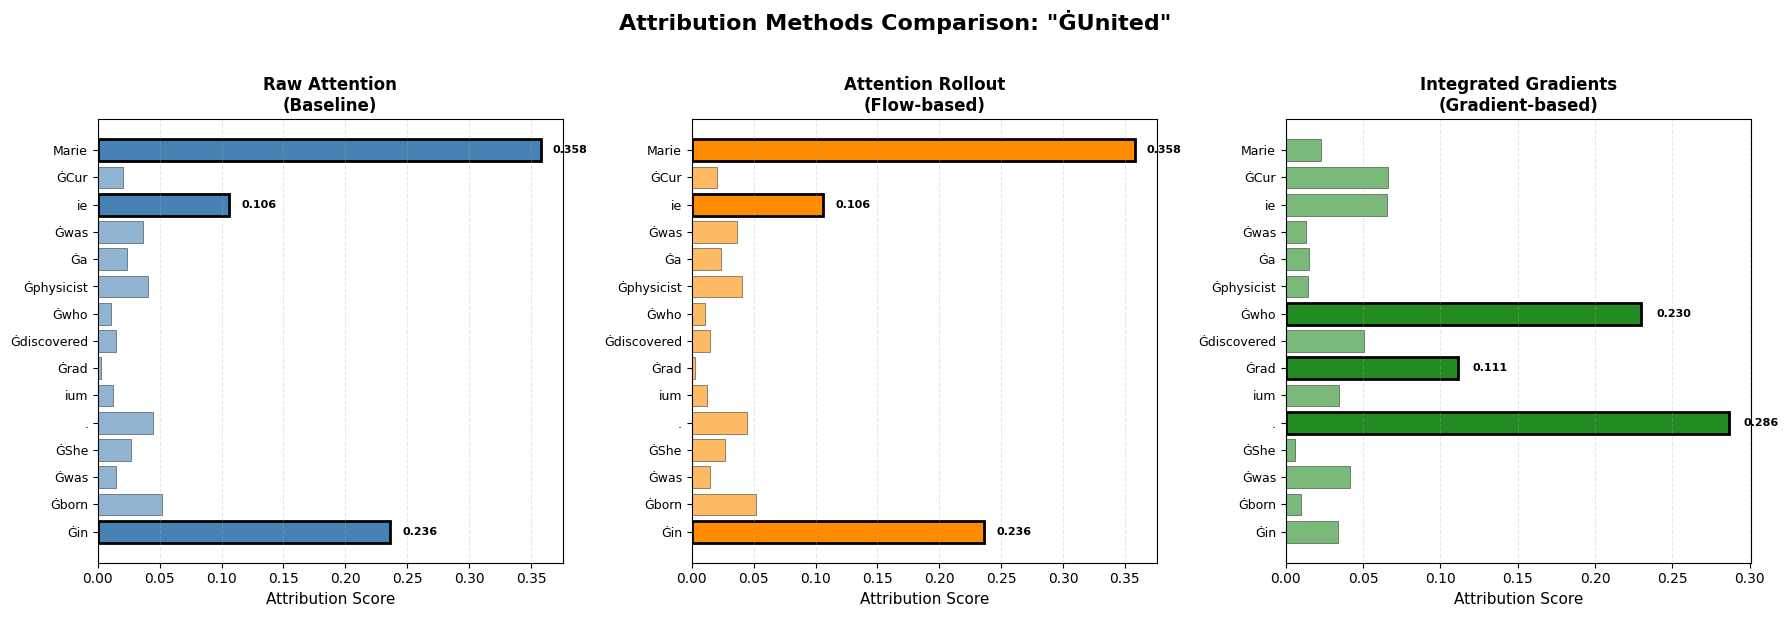

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle(f'Attribution Methods Comparison: "{all_tokens[target_position]}"', 
             fontsize=16, fontweight='bold', y=1.02)
methods = ['raw_attention', 'attention_rollout', 'integrated_gradients']
titles = ['Raw Attention\n(Baseline)', 'Attention Rollout\n(Flow-based)', 'Integrated Gradients\n(Gradient-based)']
colors = ['steelblue', 'darkorange', 'forestgreen']
for ax, method, title, color in zip(axes, methods, titles, colors):
    values = df_comparison[method].values
    tokens = df_comparison['token'].values
    bars = ax.barh(range(len(values)), values, color=color, alpha=0.6, edgecolor='black', linewidth=0.5)
    top_3_idx = np.argsort(values)[-3:]
    for idx in top_3_idx:
        bars[idx].set_alpha(1.0)
        bars[idx].set_edgecolor('black')
        bars[idx].set_linewidth(2)
    ax.set_yticks(range(len(tokens)))
    ax.set_yticklabels(tokens, fontsize=9)
    ax.set_xlabel('Attribution Score', fontsize=11)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    ax.invert_yaxis()
    for idx in top_3_idx:
        ax.text(values[idx] + 0.01, idx, f'{values[idx]:.3f}', 
               va='center', fontsize=8, fontweight='bold')
plt.tight_layout()
os.makedirs('../outputs', exist_ok=True)
plt.savefig('../outputs/04_attribution_comparison.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

Attention methods (blue/orange):
- Focus on "Marie" and "in" where the model looked
- Both give identical results (attention doesn't capture causation)

Integrated Gradients (green):
- Reveals "." (period) and "who" actually caused "United"
- Sentence structure triggered the hallucination, not the name itself

4. Head level attribution analysis to understand which specific attention heads contribute most to the target token?

In [16]:
def compute_head_level_attribution(attentions, target_step_idx):
    """
    Compute total attention from each head to the target token.
    Args:
        attentions: List of attention tensors (one per generation step)
        target_step_idx: Generation step where target token appears
    Returns:
        head_scores: Dict[str, float] - {"L{layer}_H{head}": score}
    """
    head_scores = {}
    layer_attns = attentions[target_step_idx]
    for layer_idx, layer_attn in enumerate(layer_attns):
        for head_idx in range(layer_attn.shape[1]):
            head_attn = layer_attn[0, head_idx]  # (seq_len, seq_len)
            total_attn = head_attn[:, -1].sum().item()
            head_scores[f"L{layer_idx}_H{head_idx}"] = total_attn
    return head_scores

In [17]:
head_attribution = compute_head_level_attribution(output.attentions, target_step)
df_heads = pd.DataFrame([
    {'head': k, 'score': v} for k, v in head_attribution.items()
]).sort_values('score', ascending=False)

In [18]:
# Identifying which layers dominates
df_heads['layer'] = df_heads['head'].str.extract(r'L(\d+)').astype(int)
layer_totals = df_heads.groupby('layer')['score'].sum().sort_values(ascending=False)

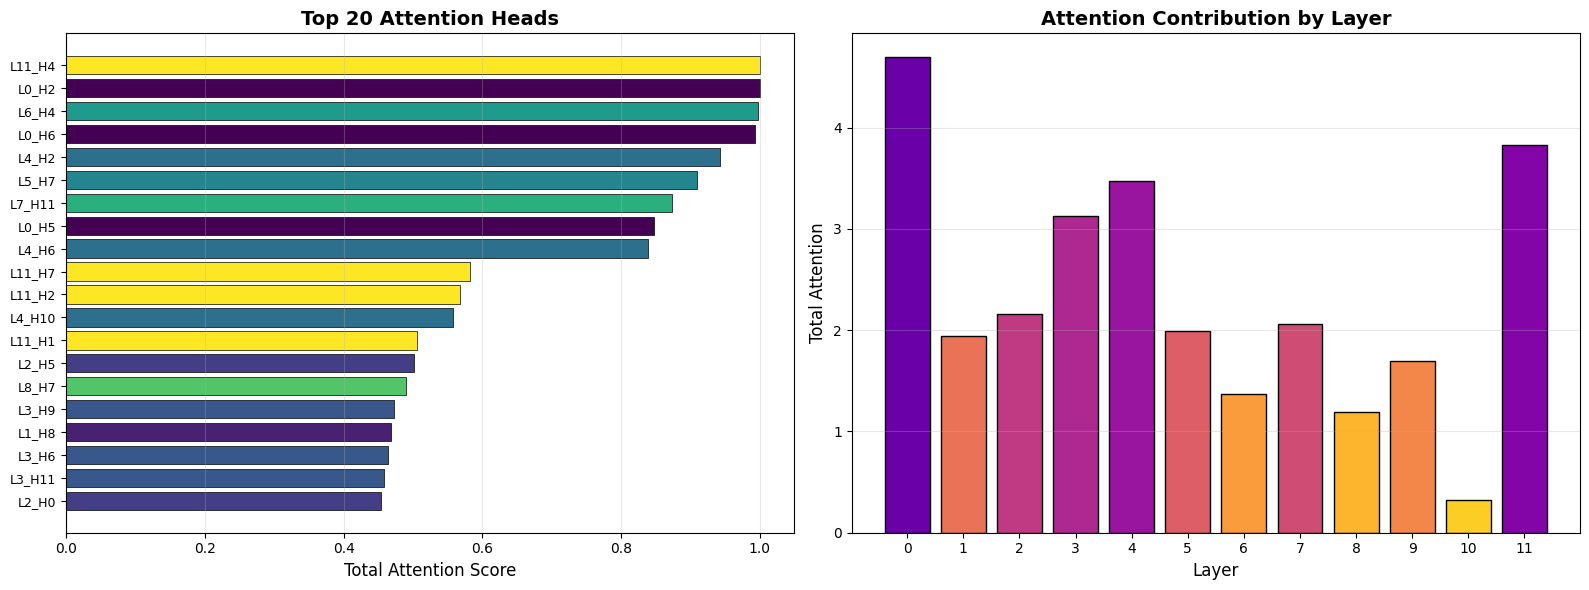

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
# Plot 1: Top 20 heads
top_20 = df_heads.head(20)
colors_heads = plt.cm.viridis(top_20['layer'].values / 11)  # Color by layer
ax1.barh(range(len(top_20)), top_20['score'].values, color=colors_heads, edgecolor='black', linewidth=0.5)
ax1.set_yticks(range(len(top_20)))
ax1.set_yticklabels(top_20['head'].values, fontsize=9)
ax1.set_xlabel('Total Attention Score', fontsize=12)
ax1.set_title('Top 20 Attention Heads', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)
ax1.invert_yaxis()
# Plot 2: Aggregated by layer
layer_colors = plt.cm.plasma(np.linspace(0.2, 0.9, len(layer_totals)))
ax2.bar(layer_totals.index, layer_totals.values, color=layer_colors, edgecolor='black', linewidth=1)
ax2.set_xlabel('Layer', fontsize=12)
ax2.set_ylabel('Total Attention', fontsize=12)
ax2.set_title('Attention Contribution by Layer', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
ax2.set_xticks(range(12))
plt.tight_layout()
plt.savefig('../outputs/04_head_attribution.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

Top 20 Heads:

- Layer 11 Head 4 dominates (yellow, highest bar) - final layer doing heavy lifting
- Early layers (L0-L4) and late layers (L6-L11) both represented - distributed processing

By Layer:

- Layer 0 and Layer 11 are peaks - input processing and final output
- Middle layers (5-10) contribute less - information flows through them to endpoints

5. Exporting attribution data for viz

In [20]:
attribution_data = {
    'target_token': all_tokens[target_position],
    'target_position': target_position,
    'target_token_id': target_token_id,
    'input_tokens': input_tokens,
    'raw_attention': raw_attribution.tolist(),
    'attention_rollout': rollout_attribution.tolist(),
    'integrated_gradients': ig_attribution.tolist(),
    'head_attribution': head_attribution,
    'top_heads': df_heads.head(20).to_dict('records')
}

In [21]:
with open('../outputs/04_attribution_data.json', 'w') as f:
    json.dump(attribution_data, f, indent=2)

**Next: 05 Interactive Visualizations**

Notebook 04 identified WHICH tokens (".", "who") and heads (Layer 11 Head 4) causally drive the hallucination, but not HOW information flows through the network to produce it.

Notebook 05 creates interactive visualizations: Sankey flow diagrams, temporal attribution movies, 3D circuit graphs, nationality subspace projections, and minimal intervention analysis to trace the complete pathway from "Marie" through 144 attention heads to "United", revealing when and where the error becomes locked in during generation.